In [21]:
# https://www.tensorflow.org/decision_forests/tutorials/beginner_colab
# https://www.tensorflow.org/decision_forests/tutorials/predict_colab
# https://www.tensorflow.org/decision_forests/tutorials/advanced_colab 

from google.cloud import bigquery

import pandas as pd
import numpy as np

import math
import os

import tensorflow as tf
print(tf.__version__)



2.12.0


In [22]:
#pip install tensorflow_decision_forests --upgrade --user
import tensorflow_decision_forests as tfdf
print(tfdf.__version__)

1.4.0


# Variable to Configuration

In [23]:
model_tree_type=1# 1= xgboost  2=random forest
option_cate_feature=2 # the best formance

#labelCol='label_multi_severity'
labelCol='label_binary_severity'

In [24]:
projectId='pongthorn'
dataset_id='SMartML'

train_name='train2_incident'
test_name='test2_incident'

train_table_id=f"{projectId}.{dataset_id}.{train_name}"
test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"
print(f"train-ds = {train_table_id}")
print(f"test-ds = {test_tabel_id}")

train-ds = pongthorn.SMartML.train2_incident
test-ds = pongthorn.SMartML.test2_incident


In [25]:
metric="accuracy"
if  labelCol=='label_multi_severity':
    if model_tree_type==1:
        _model='multi_xgb_tf_model'
    else:
         _model='multi_rf_tf__model'
else:
    if model_tree_type==1:
        _model='demo_binary_xgb_tf_model'
    else:
         _model='demo_binary_rf_tf_model'

model_gs_path=f"gs://demo-tf-incident-pongthorn/{_model}"
print(model_gs_path)
#model_local_path=_model

gs://demo-tf-incident-pongthorn/demo_binary_xgb_tf_model


In [26]:
if option_cate_feature==1:
    # cateCols=['sla','product_type','brand','service_type','incident_type','range_open_to_close_hour','range_response_to_resolved_hour']
    cateCols=['sla','product_type','brand','service_type','incident_type','range_open_to_close_hour']
    numbericCols=[]
    #unusedCols=['id','severity_id','severity_name','label_binary_severity','open_to_close_hour','response_to_resolved_hour']
    if labelCol=='label_multi_severity':
     unusedCols=['id','severity_id','severity_name','open_to_close_hour','label_binary_severity']
    else:
     unusedCols=['id','severity_id','severity_name','open_to_close_hour','label_multi_severity']   
else:
    cateCols=['sla','product_type','brand','service_type','incident_type']
    numbericCols=['open_to_close_hour']
    if labelCol=='label_multi_severity':
     unusedCols=['id','severity_id','severity_name','range_open_to_close_hour','label_binary_severity']
    else:
      unusedCols=['id','severity_id','severity_name','range_open_to_close_hour','label_multi_severity']  


print(f"CateCols : {cateCols}")
print(f"NumbericCols : {numbericCols}")
print(f"UnusedCols : {unusedCols}")

CateCols : ['sla', 'product_type', 'brand', 'service_type', 'incident_type']
NumbericCols : ['open_to_close_hour']
UnusedCols : ['id', 'severity_id', 'severity_name', 'range_open_to_close_hour', 'label_multi_severity']


# Load & Prepare Data

In [27]:
def load_ml_data(data_path):
 df=pd.read_csv(data_path)
 df =df.drop(columns=unusedCols)
 
 return df

def load_data_bq(sql:str):
 
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 df =df.drop(columns=unusedCols)
 df[labelCol]=df[labelCol].astype('int64') 
 df=df[[labelCol]+cateCols+numbericCols]   
  
 return df

In [40]:
client = bigquery.Client(project=projectId)

train=load_data_bq(f"SELECT * FROM {train_table_id}")
test=load_data_bq(f"SELECT * FROM {test_tabel_id}")

print(train.info())

print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2349 entries, 0 to 2348
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   label_binary_severity  2349 non-null   int64  
 1   sla                    2349 non-null   object 
 2   product_type           2349 non-null   object 
 3   brand                  2349 non-null   object 
 4   service_type           2349 non-null   object 
 5   incident_type          2349 non-null   object 
 6   open_to_close_hour     2349 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 128.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   label_binary_severity  588 non-null    int64  
 1   sla                    588 non-null    object 
 2   product_type           588 non-null    o

# Explore & Visualize Target Class Label

In [41]:
classes_train = list(train[labelCol].unique())
classes_test = list(test[labelCol].unique())

set_classes=set(classes_train) & set(classes_test)
classes=list(set_classes)
print(classes)



[0, 1]


1(Critical) in Train=1213 and  1(Critical) in Test=327
Train: Ratio of 1(Critical) to AllLabels is 0.52
Test: Ratio of 1(Critical) to AllLabels is 0.56


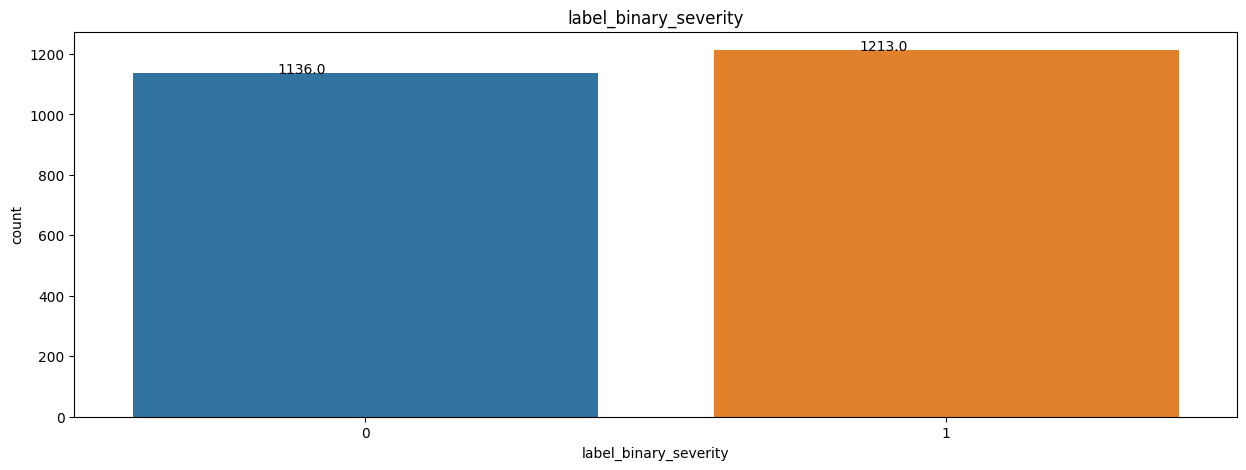

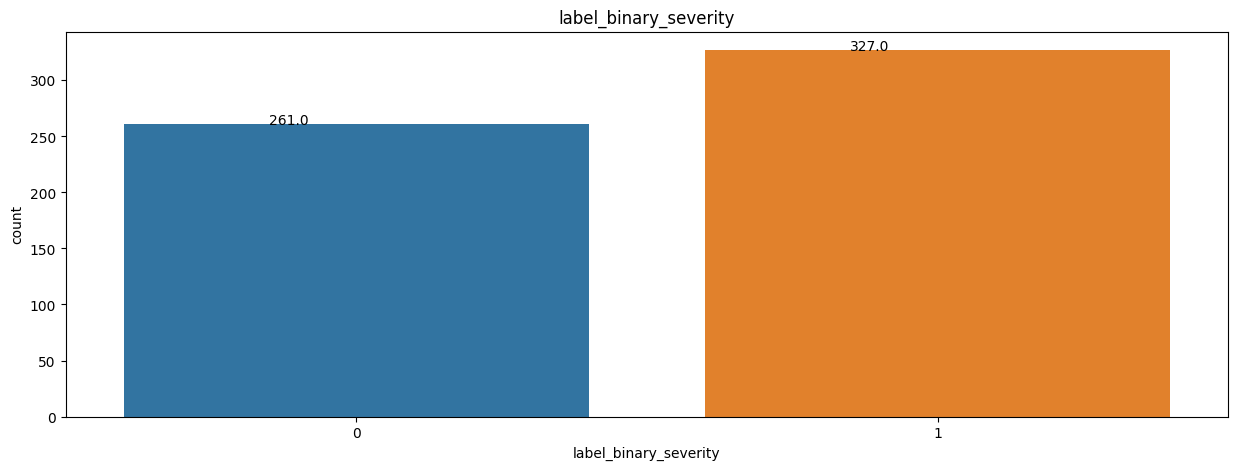

In [51]:
no_1_train=len(train.query(f"{labelCol}==1"))
no_1_test=len(test.query(f"{labelCol}==1"))
print(f"1(Critical) in Train={no_1_train} and  1(Critical) in Test={no_1_test}")

print(f"Train: Ratio of 1(Critical) to AllLabels is {round(no_1_train/len(train),2)}")
print(f"Test: Ratio of 1(Critical) to AllLabels is {round(no_1_test/len(test),2)}")

import seaborn as sns
import matplotlib.pyplot  as plt
def plot_label(df_):

    fig , ax = plt.subplots(figsize=(15,5))
    ax =sns.countplot(x=labelCol, data=df_,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title(labelCol)
    plt.show()
        
plot_label(train)
plot_label(test)

In [52]:
train.tail(5)

,label_binary_severity,sla,product_type,brand,service_type,incident_type,open_to_close_hour
2344,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,OS / Firmware,1193.283333
2345,0,24x7 6Hrs Resolution Time,Software,Trend Micro,Request,General Incident,5.483333
2346,0,24x7 6Hrs Resolution Time,Software,Trend Micro,Request,General Incident,0.883333
2347,0,24x7 4Hrs Response Time,Security,Trend Micro,Request,General Incident,0.333333
2348,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,220.333333


In [53]:
test.tail()

,label_binary_severity,sla,product_type,brand,service_type,incident_type,open_to_close_hour
583,0,24x7 4Hrs Response Time,Security,Trend Micro,Request,Upgrade Software,264.950000
584,0,24x7 4Hrs Response Time,Security,Trend Micro,Incident,Upgrade Software,2.000000
585,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,Software,360.800000
586,1,24x7 6Hrs Resolution Time,Software,Trend Micro,Incident,General Incident,21.883333
587,1,24x7 6Hrs Resolution Time,Software,Trend Micro,Incident,General Incident,13.316667


# Convert dataframe to tensorflow dataset

In [54]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label=labelCol)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label=labelCol)

# Build Model

In [55]:
# Specify the model.
if model_tree_type==1:
    print("GradientBoostedTreesModel")
    model=tfdf.keras.GradientBoostedTreesModel()
else:
    print("RandomForestModel")
    model = tfdf.keras.RandomForestModel()

model.fit(x=train_ds)

GradientBoostedTreesModel
Use /var/tmp/tmpnez6posa as temporary training directory
Reading training dataset...


[WARNING 23-08-06 12:41:44.2435 UTC gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-06 12:41:44.2446 UTC gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-06 12:41:44.2451 UTC gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-08-06 12:41:44.313938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [2349]
	 [[{{node Placeholder/_4}}]]


Training dataset read in 0:00:04.338373. Found 2349 examples.
Training model...
Model trained in 0:00:00.452772
Compiling model...


[INFO 23-08-06 12:41:48.9728 UTC kernel.cc:1243] Loading model from path /var/tmp/tmpnez6posa/model/ with prefix 1a7b1c3944f24706
[INFO 23-08-06 12:41:49.0738 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-08-06 12:41:49.0746 UTC kernel.cc:1075] Use fast generic engine
2023-08-06 12:41:49.132247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2349]
	 [[{{node Placeholder/_1}}]]


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [56]:
model.compile(metrics=[metric])
evaluation = model.evaluate(test_ds, return_dict=True)
for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

2023-08-06 12:41:57.738983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype int64 and shape [588]
	 [[{{node Placeholder/_6}}]]


1/1 [==============================] - 1s 733ms/step - loss: 0.0000e+00 - accuracy: 0.8180
loss: 0.0000
accuracy: 0.8180


# Inspect and debug decision forest models
## Model structure and feature importance

In [58]:

inspector=model.make_inspector()

print("Model type:", inspector.model_type())
print("Number of trees:", inspector.num_trees())
print("Objective:", inspector.objective())
print("Input features:", inspector.features())

#[field for field in dir(inspector) if not field.startswith("_")]
# SUM_SCORE ,NUM_AS_ROOT

Model type: GRADIENT_BOOSTED_TREES
Number of trees: 50
Objective: Classification(label=__LABEL, class=None, num_classes=2)
Input features: ["brand" (4; #1), "incident_type" (4; #2), "open_to_close_hour" (1; #3), "product_type" (4; #4), "service_type" (4; #5), "sla" (4; #6)]


In [71]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 SUM_SCORE
	 NUM_NODES
	 NUM_AS_ROOT
	 INV_MEAN_MIN_DEPTH


# Model Self Evaluation

In [59]:
inspector.evaluation()

Evaluation(num_examples=None, accuracy=0.8439024686813354, loss=0.6960360407829285, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

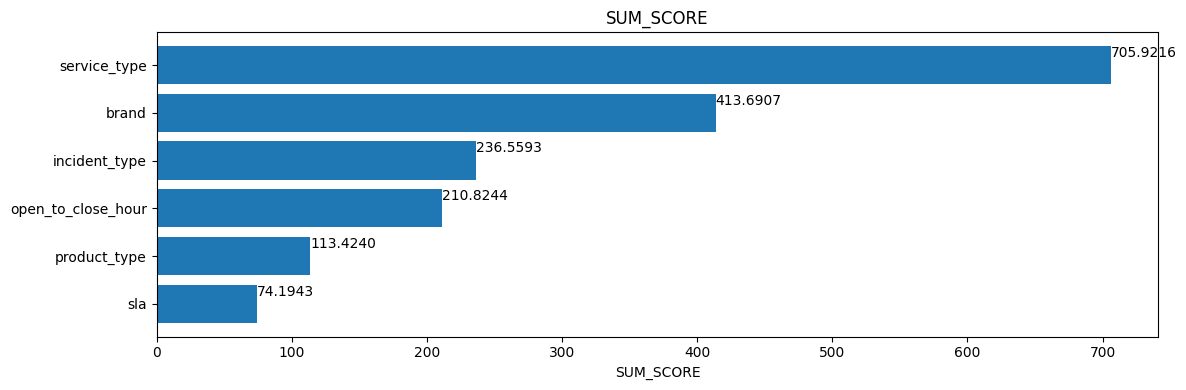

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "SUM_SCORE"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title(variable_importance_metric)
plt.tight_layout()
plt.show()

# Plot the model

In [61]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3)

# Plotting the training logs

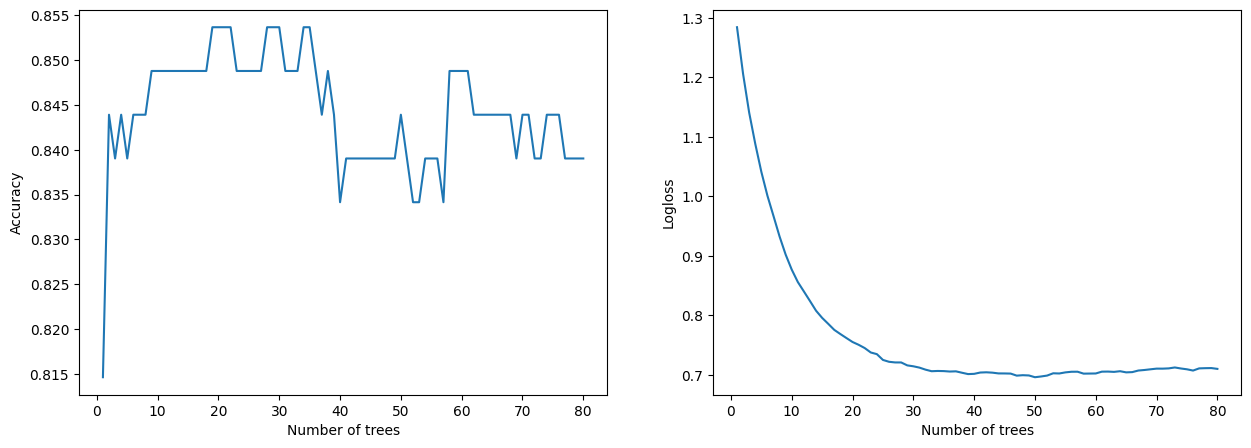

In [62]:
import matplotlib.pyplot as plt

logs = model.make_inspector().training_logs()

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss")

plt.show()

# Save Model

In [63]:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/distribute/save_and_load.ipynb#scrollTo=jFcuzsI94bNA
#save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
# model.save(model_gs_path,options=save_options)
# model.save(model_local_path,options=save_options)
model.save(model_gs_path)

INFO:tensorflow:Assets written to: gs://demo-tf-incident-pongthorn/demo_binary_xgb_tf_model/assets


INFO:tensorflow:Assets written to: gs://demo-tf-incident-pongthorn/demo_binary_xgb_tf_model/assets
